In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.utils.tensorboard as tb
from Preprocessing.preprocessing_sorted import PreprocessingTrainingData
from torch.utils.data.sampler import SequentialSampler
import seaborn as sns
import matplotlib.pyplot as  plt
import os
import logging
torch.set_printoptions(profile="full")
import pandas as pd

In [2]:
#static parameters
train_batch_size = 30
val_batch_size = 30
sequence_length=50
test_batch_size = 1
input_size = 1
hidden_size = 256
num_layer = 2
output_size = 38
clip = 3

In [3]:
#get data from preprocessing.py
dataset_path = os.path.join(os.path.abspath('..'),'Dataset\\Clementi dataset\\Clementi dataset' )
network_input,network_output,max_midi_number,min_midi_number,int_to_note = PreprocessingTrainingData().preprocess_notes(dataset_path)
network_input, network_output = network_input.cuda(), network_output.cuda()

# print(network_input)
#print(network_output)

In [4]:
print(network_output.max())
print(network_output.min())

tensor(37, device='cuda:0')
tensor(0, device='cuda:0')


In [5]:
#network_output

In [6]:
print(network_input.max())
print(network_input.min())
print(max_midi_number)
print(min_midi_number)
print(int_to_note)

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
89
50
{0: 50, 1: 52, 2: 53, 3: 54, 4: 55, 5: 56, 6: 57, 7: 58, 8: 59, 9: 60, 10: 61, 11: 62, 12: 63, 13: 64, 14: 65, 15: 66, 16: 67, 17: 68, 18: 69, 19: 70, 20: 71, 21: 72, 22: 73, 23: 74, 24: 75, 25: 76, 26: 77, 27: 78, 28: 79, 29: 80, 30: 81, 31: 82, 32: 83, 33: 84, 34: 85, 35: 86, 36: 88, 37: 89}


In [7]:
# '''
# data is highly unbalanced
# # '''
# sns.distplot(torch.tensor(network_output).cpu())
# xx = pd.DataFrame(torch.tensor(network_output).cpu())
# xx.groupby(0).size().to_frame(name='values')

In [8]:
'''
to make batch of equal sizes
Quick Fix
'''
network_input = network_input[: -29]
network_output = network_output[: -29]

print(network_input.shape)
print(network_output.shape)

torch.Size([1800, 50, 1])
torch.Size([1800])


In [9]:
#network_input[0]

In [10]:
'''
create Stacked LSTM model
'''
class Stacked_LSTM(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, output_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm1 = nn.LSTM(input_size = input_size, hidden_size = hidden_size, batch_first = True)
        self.lstm2 = nn.LSTM(input_size = hidden_size, hidden_size = output_size,batch_first = True)
        
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(output_size, output_size)
        
        
    def forward(self, x, hidden1, hidden2,batch_size):
        
        output, _ = self.lstm1(x)        
        #print(output.shape)
        
        #output = self.dropout(output)
        
        output, _ = self.lstm2(output)
        #print(output.shape)
        
        # stack up lstm outputs
        output = output.contiguous().view(-1, 38)
        #print(output.shape)
        
        output = self.dropout(output)
        output = self.linear(output)
        #print('Linear Output :-',output.shape)
        
        #output = F.softmax(output, dim = 1)
        #print('SOFTMAX OUTPUT :--', output)
        
        
        # reshape to be batch_size first
        output = output.view(batch_size, -1)
        #print('Reshape to batch size first :-',output.shape)
        
        output = output[:, -self.output_size:] # get last batch of labels
        #print('Final Output :-',output)
        #print('RESHAPE SIZE :-', output.shape)
        
        return output, hidden2
    
    def hidden_init(self,batch_size):
        
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden1 = (weight.new(1, batch_size, self.hidden_size).zero_().cuda(),
          weight.new(1, batch_size, self.hidden_size).zero_().cuda())
        
        hidden2 = (weight.new(1, batch_size, 38).zero_().cuda(),
          weight.new(1, batch_size, 38).zero_().cuda())
        return hidden1,hidden2

#initialize the weights of LSTM using Xavier initialization    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

    

In [19]:
'''
Divide the dataset into train/val 
'''
train_size = 0.8
indices = list(range(len(network_input)))
split = int(np.floor(train_size*len(network_input)))
train_idx, val_idx = indices[:split], indices[split:]

train_sampler = SequentialSampler(train_idx)
val_sampler = SequentialSampler(val_idx)

dataset = TensorDataset(network_input,network_output)
train_loader = DataLoader(dataset, batch_size= train_batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size= val_batch_size,sampler= val_sampler)

In [20]:
import torch.optim as optimizer

model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optimizer.AdamW(model.parameters())
#optimizer = optimizer.RMSprop(model.parameters(), lr = 0.001, weight_decay = 0.01)


#make sure to transfer model to GPU after initializing optimizer
model.cuda()

Stacked_LSTM(
  (lstm1): LSTM(1, 256, batch_first=True)
  (lstm2): LSTM(256, 38, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=38, out_features=38, bias=True)
)

In [21]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)

In [22]:
#hidden = model.hidden_init(train_batch_size) 
#hidden

In [23]:
epochs = 500
min_val_loss = np.Inf

for e in range(epochs):
    
    train_loss = 0
    val_loss = 0
    train_accuracy = 0
    val_accuracy = 0
    
    
    hidden1, hidden2 = model.hidden_init(train_batch_size)    
    #print('hidden[0].shape:- ',hidden[0].shape)
    
    for inputs,labels in train_loader:
        #print(inputs.shape)

        '''
        Creating new variables for the hidden state, otherwise
        we'd backprop through the entire training history
        '''
        #h = tuple([each.data for each in hidden])
        
        h1 = tuple([each.data for each in hidden1])
        h2 = tuple([each.data for each in hidden2])
        
        # zero accumulated gradients
        model.zero_grad()
       
        # get the output from the model
        output, _ = model.forward(inputs, h1, h2, train_batch_size)
        #print('OUTPUT', output)
        
        
        #print('Labels Shape :-', (torch.max(labels, 1)[1]).shape)
    
        # calculate the loss and perform backprop
        #print('Labels Long :-', labels.long())
        loss = criterion(output,labels.long())
        #print('LOSS IS :-', loss)
        
        loss.backward()
        
        #calculate training accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        logging.debug(' top probab {} top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        equals = top_class == labels.long().view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        #nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        train_loss += loss.item()
        #print(train_loss)
              
    model.eval()
    for inputs, labels in val_loader:
                
        val_h1 = tuple([each.data for each in hidden1])
        val_h2 = tuple([each.data for each in hidden2])
        
        output, _ = model.forward(inputs, val_h1, val_h2,val_batch_size)
       
        loss = criterion(output,labels.long())
        
        val_loss += loss.item()
        
        #calculate validation accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        
        #logging.debug(output)
        #logging.debug('VALIDATION top probab {} VALIDATION top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        #print('Top Class:- ',top_class)
        equals = top_class == labels.long().view(*top_class.shape)
        #print('Equals:- ', equals)
        val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    model.train()
    
    #Averaging losses
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    val_accuracy = val_accuracy/len(val_loader)
    train_accuracy = train_accuracy/len(train_loader)
    
    print('Epoch: {}\tTrain Loss: {:.7f} \tVal Loss:{:.7f} \tTrain Acc: {:.7}% \tVal Acc: {:.7f}%'.format(e, train_loss, val_loss, train_accuracy*100,val_accuracy*100))
    
    #saving the model if validation loss is decreased
    if val_loss <= min_val_loss:
        print('Validation Loss decreased from {:6f} to {:6f}, saving the model weights'.format(min_val_loss, val_loss))
        torch.save(model.state_dict(), 'lstm_state_256-38-removed_Ht_Ct_sorted.pt')
        min_val_loss = val_loss

Epoch: 0	Train Loss: 3.6135258 	Val Loss:3.3890666 	Train Acc: 3.472222% 	Val Acc: 2.5000001%
Validation Loss decreased from    inf to 3.389067, saving the model weights
Epoch: 1	Train Loss: 3.4644557 	Val Loss:3.2165629 	Train Acc: 4.375% 	Val Acc: 8.8888892%
Validation Loss decreased from 3.389067 to 3.216563, saving the model weights
Epoch: 2	Train Loss: 3.3983936 	Val Loss:3.1819957 	Train Acc: 5.0% 	Val Acc: 8.8888892%
Validation Loss decreased from 3.216563 to 3.181996, saving the model weights
Epoch: 3	Train Loss: 3.3525703 	Val Loss:3.1572540 	Train Acc: 4.305556% 	Val Acc: 8.8888892%
Validation Loss decreased from 3.181996 to 3.157254, saving the model weights
Epoch: 4	Train Loss: 3.3574908 	Val Loss:3.1589651 	Train Acc: 5.763889% 	Val Acc: 8.8888892%
Epoch: 5	Train Loss: 3.3464160 	Val Loss:3.1547901 	Train Acc: 4.444445% 	Val Acc: 8.8888892%
Validation Loss decreased from 3.157254 to 3.154790, saving the model weights
Epoch: 6	Train Loss: 3.3464063 	Val Loss:3.1507978 	Trai

Epoch: 62	Train Loss: 2.7103421 	Val Loss:2.6292700 	Train Acc: 14.44444% 	Val Acc: 14.4444448%
Validation Loss decreased from 2.662868 to 2.629270, saving the model weights
Epoch: 63	Train Loss: 2.6929862 	Val Loss:2.6300297 	Train Acc: 15.20833% 	Val Acc: 15.2777783%
Epoch: 64	Train Loss: 2.6864750 	Val Loss:2.6113246 	Train Acc: 17.01389% 	Val Acc: 14.1666671%
Validation Loss decreased from 2.629270 to 2.611325, saving the model weights
Epoch: 65	Train Loss: 2.6801782 	Val Loss:2.5701243 	Train Acc: 15.83333% 	Val Acc: 14.4444449%
Validation Loss decreased from 2.611325 to 2.570124, saving the model weights
Epoch: 66	Train Loss: 2.6774459 	Val Loss:2.5638383 	Train Acc: 15.83333% 	Val Acc: 13.6111115%
Validation Loss decreased from 2.570124 to 2.563838, saving the model weights
Epoch: 67	Train Loss: 2.6465983 	Val Loss:2.5435428 	Train Acc: 16.45833% 	Val Acc: 12.7777781%
Validation Loss decreased from 2.563838 to 2.543543, saving the model weights
Epoch: 68	Train Loss: 2.6102305 	V

Epoch: 121	Train Loss: 1.9644642 	Val Loss:1.7966507 	Train Acc: 37.70833% 	Val Acc: 44.4444458%
Epoch: 122	Train Loss: 1.9558278 	Val Loss:1.7268575 	Train Acc: 37.43056% 	Val Acc: 46.9444450%
Validation Loss decreased from 1.778157 to 1.726858, saving the model weights
Epoch: 123	Train Loss: 1.9055952 	Val Loss:1.7248940 	Train Acc: 40.48611% 	Val Acc: 47.2222229%
Validation Loss decreased from 1.726858 to 1.724894, saving the model weights
Epoch: 124	Train Loss: 1.8640061 	Val Loss:1.8001494 	Train Acc: 41.31945% 	Val Acc: 45.2777782%
Epoch: 125	Train Loss: 1.8515469 	Val Loss:1.7737708 	Train Acc: 39.79167% 	Val Acc: 45.0000010%
Epoch: 126	Train Loss: 1.8364293 	Val Loss:1.6948985 	Train Acc: 41.73611% 	Val Acc: 49.7222231%
Validation Loss decreased from 1.724894 to 1.694899, saving the model weights
Epoch: 127	Train Loss: 1.8300293 	Val Loss:1.6624904 	Train Acc: 40.41667% 	Val Acc: 48.0555565%
Validation Loss decreased from 1.694899 to 1.662490, saving the model weights
Epoch: 12

Epoch: 184	Train Loss: 0.9086494 	Val Loss:0.7386254 	Train Acc: 72.56944% 	Val Acc: 81.9444438%
Epoch: 185	Train Loss: 0.9221551 	Val Loss:0.7135111 	Train Acc: 72.22222% 	Val Acc: 84.4444434%
Epoch: 186	Train Loss: 0.9053691 	Val Loss:0.6477178 	Train Acc: 72.5% 	Val Acc: 86.3888885%
Validation Loss decreased from 0.687565 to 0.647718, saving the model weights
Epoch: 187	Train Loss: 0.8675247 	Val Loss:0.6656148 	Train Acc: 73.95833% 	Val Acc: 86.3888885%
Epoch: 188	Train Loss: 0.8723393 	Val Loss:0.6243101 	Train Acc: 75.06944% 	Val Acc: 85.2777774%
Validation Loss decreased from 0.647718 to 0.624310, saving the model weights
Epoch: 189	Train Loss: 0.8459058 	Val Loss:0.6336020 	Train Acc: 73.88889% 	Val Acc: 84.1666664%
Epoch: 190	Train Loss: 0.8387265 	Val Loss:0.6217835 	Train Acc: 75.55556% 	Val Acc: 88.3333315%
Validation Loss decreased from 0.624310 to 0.621783, saving the model weights
Epoch: 191	Train Loss: 0.8412951 	Val Loss:0.6378441 	Train Acc: 74.58333% 	Val Acc: 86.944

Epoch: 247	Train Loss: 1.2498454 	Val Loss:0.9882799 	Train Acc: 63.47222% 	Val Acc: 73.8888887%
Epoch: 248	Train Loss: 1.0910316 	Val Loss:0.8004567 	Train Acc: 67.56944% 	Val Acc: 75.0000005%
Epoch: 249	Train Loss: 0.8591747 	Val Loss:0.5122807 	Train Acc: 73.75% 	Val Acc: 86.9444440%
Epoch: 250	Train Loss: 0.5738717 	Val Loss:0.2516809 	Train Acc: 83.54167% 	Val Acc: 93.0555542%
Epoch: 251	Train Loss: 0.5170367 	Val Loss:0.2267343 	Train Acc: 84.02778% 	Val Acc: 93.0555537%
Epoch: 252	Train Loss: 0.4459616 	Val Loss:0.1807300 	Train Acc: 86.04167% 	Val Acc: 96.6666659%
Epoch: 253	Train Loss: 0.3778739 	Val Loss:0.1740196 	Train Acc: 90.13889% 	Val Acc: 95.8333328%
Epoch: 254	Train Loss: 0.3328993 	Val Loss:0.1342395 	Train Acc: 90.55555% 	Val Acc: 97.2222214%
Epoch: 255	Train Loss: 0.3023036 	Val Loss:0.1100277 	Train Acc: 92.01389% 	Val Acc: 98.6111100%
Validation Loss decreased from 0.133656 to 0.110028, saving the model weights
Epoch: 256	Train Loss: 0.2802938 	Val Loss:0.1080169

Epoch: 315	Train Loss: 0.1947793 	Val Loss:0.1477610 	Train Acc: 96.04167% 	Val Acc: 95.8333328%
Epoch: 316	Train Loss: 0.1669667 	Val Loss:0.0666374 	Train Acc: 96.11111% 	Val Acc: 98.3333329%
Epoch: 317	Train Loss: 0.1592778 	Val Loss:0.0571658 	Train Acc: 96.04167% 	Val Acc: 98.0555544%
Epoch: 318	Train Loss: 0.1619946 	Val Loss:0.0527016 	Train Acc: 95.55555% 	Val Acc: 97.7777774%
Epoch: 319	Train Loss: 0.1808147 	Val Loss:0.0480860 	Train Acc: 95.0% 	Val Acc: 98.8888885%
Epoch: 320	Train Loss: 0.2145300 	Val Loss:0.0599384 	Train Acc: 94.30555% 	Val Acc: 98.6111104%
Epoch: 321	Train Loss: 0.1795963 	Val Loss:0.0384059 	Train Acc: 95.20833% 	Val Acc: 99.1666660%
Epoch: 322	Train Loss: 0.1363067 	Val Loss:0.0357381 	Train Acc: 97.08333% 	Val Acc: 99.1666665%
Epoch: 323	Train Loss: 0.1232877 	Val Loss:0.0343166 	Train Acc: 97.5% 	Val Acc: 98.8888890%
Validation Loss decreased from 0.034933 to 0.034317, saving the model weights
Epoch: 324	Train Loss: 0.1026344 	Val Loss:0.0358769 	Tra

Epoch: 389	Train Loss: 0.1358666 	Val Loss:0.0374672 	Train Acc: 96.52778% 	Val Acc: 98.6111100%
Epoch: 390	Train Loss: 0.1126697 	Val Loss:0.0240070 	Train Acc: 97.15278% 	Val Acc: 98.8888885%
Epoch: 391	Train Loss: 0.1020878 	Val Loss:0.0190240 	Train Acc: 97.15278% 	Val Acc: 99.4444440%
Epoch: 392	Train Loss: 0.1133993 	Val Loss:0.0267511 	Train Acc: 96.52778% 	Val Acc: 98.8888890%
Epoch: 393	Train Loss: 0.1092082 	Val Loss:0.0312570 	Train Acc: 97.36111% 	Val Acc: 98.8888885%
Epoch: 394	Train Loss: 0.1377105 	Val Loss:0.0234293 	Train Acc: 96.11111% 	Val Acc: 99.4444440%
Epoch: 395	Train Loss: 0.2052409 	Val Loss:0.0547640 	Train Acc: 95.0% 	Val Acc: 98.0555549%
Epoch: 396	Train Loss: 0.2612975 	Val Loss:0.5201087 	Train Acc: 93.19444% 	Val Acc: 86.1111109%
Epoch: 397	Train Loss: 0.4315081 	Val Loss:0.2917226 	Train Acc: 87.29167% 	Val Acc: 89.9999991%
Epoch: 398	Train Loss: 0.3449282 	Val Loss:0.1498595 	Train Acc: 90.20833% 	Val Acc: 95.5555553%
Epoch: 399	Train Loss: 0.2731484 	

Epoch: 468	Train Loss: 0.5681535 	Val Loss:0.2033309 	Train Acc: 84.16667% 	Val Acc: 94.7222213%
Epoch: 469	Train Loss: 0.2986304 	Val Loss:0.2527193 	Train Acc: 92.36111% 	Val Acc: 93.8888888%
Epoch: 470	Train Loss: 0.2354663 	Val Loss:0.0452364 	Train Acc: 93.33333% 	Val Acc: 99.1666665%
Epoch: 471	Train Loss: 0.1317320 	Val Loss:0.0282157 	Train Acc: 96.38889% 	Val Acc: 99.1666660%
Epoch: 472	Train Loss: 0.1038918 	Val Loss:0.0184738 	Train Acc: 97.36111% 	Val Acc: 99.7222220%
Epoch: 473	Train Loss: 0.0854752 	Val Loss:0.0166349 	Train Acc: 98.19444% 	Val Acc: 99.4444445%
Epoch: 474	Train Loss: 0.0709813 	Val Loss:0.0157174 	Train Acc: 99.09722% 	Val Acc: 99.4444445%
Epoch: 475	Train Loss: 0.0607323 	Val Loss:0.0148515 	Train Acc: 99.23611% 	Val Acc: 99.4444445%
Epoch: 476	Train Loss: 0.0662410 	Val Loss:0.0142134 	Train Acc: 98.61111% 	Val Acc: 99.4444440%
Epoch: 477	Train Loss: 0.0658739 	Val Loss:0.0146787 	Train Acc: 98.61111% 	Val Acc: 99.4444445%
Epoch: 478	Train Loss: 0.05840

## MUSIC GENERATION

In [33]:
#load weights
test_model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
test_model.load_state_dict(torch.load('lstm_state_256-38-removed_Ht_Ct_sorted.pt'))
test_model.eval()
test_model.cuda()

Stacked_LSTM(
  (lstm1): LSTM(1, 256, batch_first=True)
  (lstm2): LSTM(256, 38, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=38, out_features=38, bias=True)
)

In [34]:
#load population database
#testing_data = np.ones(200)*1
testing_data = list(range(50,90))
testing_data.extend(testing_data[::-1])
testing_data_rev = testing_data[::-1]
testing_data_rev.extend(testing_data)
testing_data_rev.extend(testing_data_rev)
testing_data = testing_data_rev


testing_data = np.asarray(testing_data)
testing_data = testing_data.reshape(testing_data.shape[0],1)

initial_seq = [network_input[0][1:].cpu().numpy().tolist()]

testing_data_unnorm = testing_data

In [35]:
list1=[]
testing_data=testing_data.tolist()
for i in range(len(testing_data)):
    list1.extend(testing_data[i])

#list1

for i in range(len(list1)):
    list1[i]=(list1[i]-50)/(89-50)

list1 = np.asarray(list1)
list1 = list1.reshape(list1.shape[0],1)
testing_data = list1
#list1

In [36]:
#testing_data

In [37]:
#Predicting
def prediction_with_influence(influence,int2note,initial_seq, max_note, test_batch_size = 1):

    predicted_notes = []
    initial_seq[0].extend([[0]]*len(testing_data))
    test_seq = torch.Tensor(initial_seq).cuda()
    
    h1, h2 = test_model.hidden_init(test_batch_size)

    
    for i in range(len(influence)):
        
        test_seq[0][sequence_length - 1 + i][0] = float(influence[i])
        
        test_slice = test_seq[0][i : i + sequence_length]        
        test_slice = test_slice.view(1, test_slice.shape[0], test_slice.shape[1])
                
        test_hidden1 = tuple([each.data for each in h1])
        test_hidden2 = tuple([each.data for each in h2])
        
        test_output,_ = test_model.forward(test_slice, test_hidden1, test_hidden2, test_batch_size)
    
        test_output = F.softmax(test_output, dim = 1)
        top_p, top_class = test_output.topk(1,dim =1)
        test_seq[0][sequence_length - 1 + i][0] = int2note[top_class.item()]/max_note
        
        predicted_notes.append(int2note[top_class.item()])
        
    return predicted_notes

In [38]:
predicted_notes_lst = prediction_with_influence(testing_data,int_to_note,initial_seq, max_midi_number)

In [39]:
#predicted_notes_lst

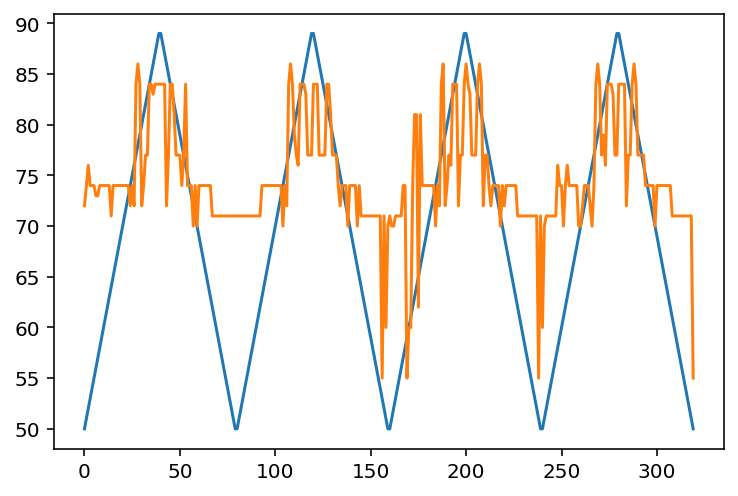

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

#plt.plot(list(np.ones(200)*89))

#plt.plot(list(np.ones(200)*50))
#plt.plot(list(np.ones(20)*50))
plt.plot(testing_data_unnorm)
plt.plot(predicted_notes_lst)

In [41]:
from collections import Counter
c = Counter(predicted_notes_lst)
c

Counter({72: 16,
         74: 103,
         76: 6,
         73: 2,
         71: 73,
         84: 42,
         86: 7,
         77: 35,
         83: 4,
         81: 5,
         70: 16,
         79: 2,
         55: 4,
         60: 4,
         62: 1})